## Sematically related network

First I want to create semantic network of hashtags:

nodes = hashtags / edges = semantic similarity

Using pre-trained word embeddings: sentence-transformers good for short text

plan: 
- Compute similarities between hashtags

- Connect similar hashtags (here have to choose treshold for similarity)

- Cluster them into communities (method: Louvain or Leiden)

In [ ]:
from sentence_transformers import SentenceTransformer
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain  # Louvain algorithm
import matplotlib.pyplot as plt
import community as community_louvain
from collections import defaultdict
import pandas as pd

sentence-transformers = library built on top of transformers and is specialized for creating embeddings of sentences, phrases, and short texts — perfect for hashtags

In [ ]:
#From Hugging Face
# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight and powerful

Questions:
how should be the graphs weighted 
what should be the treshold 
there should be the same amount opf nodes probably

In [11]:
# Load the network
import pickle

# Load the pickle file
with open('../ready_networks/likes_network.pkl', 'rb') as f:
    G = pickle.load(f)

# Get the hashtags (nodes)
hashtags = list(G.nodes)

In [8]:
print(len(hashtags))

480


In [ ]:
# Embed hashtags
embeddings = model.encode(hashtags)
print(embeddings.shape) #480 hashtags / each is represented by a 384-dimension vector

(480, 384)


In [15]:
# Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

tensor([[1.0000, 0.1839, 0.2471,  ..., 0.1695, 0.1886, 0.2671],
        [0.1839, 1.0000, 0.2504,  ..., 0.1404, 0.1452, 0.1751],
        [0.2471, 0.2504, 1.0000,  ..., 0.2773, 0.2246, 0.2392],
        ...,
        [0.1695, 0.1404, 0.2773,  ..., 1.0000, 0.1611, 0.2176],
        [0.1886, 0.1452, 0.2246,  ..., 0.1611, 1.0000, 0.1732],
        [0.2671, 0.1751, 0.2392,  ..., 0.2176, 0.1732, 1.0000]])


In [16]:
#cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

maybe we neeed to check general threshold for similarity between words so that we can set a correct treshold for 
creating an edge 

here: Only connecting two hashtags with an edge if their similarity is above 0.7.

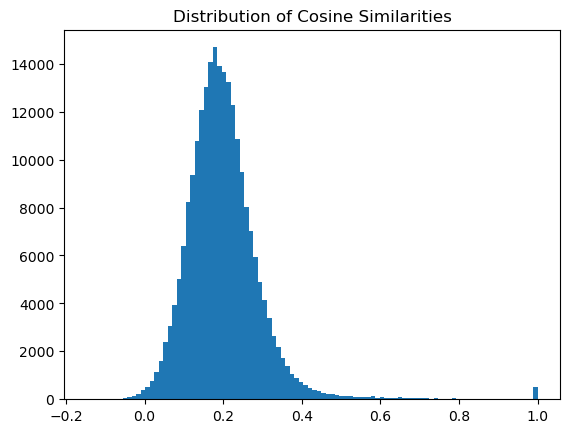

In [28]:
#have to plot a histogram to see the curt-off
import matplotlib.pyplot as plt

# similarities is your 480 x 480 cosine similarity matrix (flattened)
plt.hist(similarities.flatten(), bins=100)
plt.title('Distribution of Cosine Similarities')
plt.show()

In [32]:
# Graph
G = nx.Graph()
for i in range(len(hashtags)):
    G.add_node(hashtags[i])
    for j in range(i+1, len(hashtags)):
        if similarity_matrix[i, j] > 0.2:  # Threshold to create an edge
            G.add_edge(hashtags[i], hashtags[j], weight=similarity_matrix[i, j])

In [33]:
# Cluster with Louvain
partition = community_louvain.best_partition(G, weight='weight')

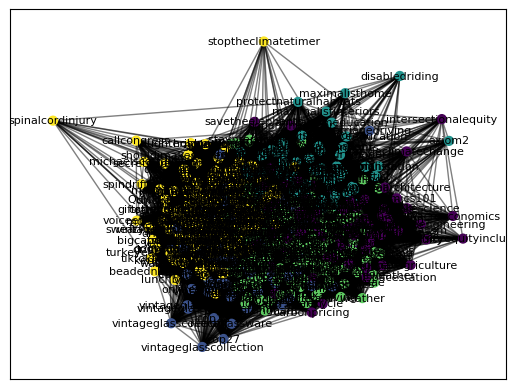

In [34]:
# Visualization
pos = nx.spring_layout(G)
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.show()

In [35]:
# Save graph to a pickle file
with open('S_R_Likes.pkl', 'wb') as f:
    pickle.dump(G, f)


## Compare communities 

comparison of community affiliants based on louvian communities across syntetically created network and the one created by us 

threshold chosen based on data exploration findings 

In [65]:
network_files = {
    "likes": "../ready_networks/likes_network.pkl",
    "s_r_likes": "S_R_Likes.pkl"
}
networks = {name: pickle.load(open(path, 'rb')) for name, path in network_files.items()}

likes = networks["likes"]
s_r_likes = networks["s_r_likes"]

overlap in communities
ratio overlap / hashtgas from real community from syntetic

direct neighbors of hahtgas with big centralities form likes network vs neighbors of sem related communities 

closest neighbors of 100 hahstags based on centralities vs. closest neighbours of those hashtgas in s_r network 


we have to account in the paper for the threshold and that it influnaces the direct relationships.

In [45]:
import community as community_louvain
from collections import defaultdict
# Detect communities using Louvain method
def detect_communities(graph):
    partition = community_louvain.best_partition(graph)
    return partition

# Compare communities between two graphs
def compare_communities(community_1, community_2):
    communities_1 = defaultdict(list)
    communities_2 = defaultdict(list)
    
    for hashtag, community in community_1.items():
        communities_1[community].append(hashtag)
    
    for hashtag, community in community_2.items():
        communities_2[community].append(hashtag)

    differences = []

    for community_1_id, hashtags_1 in communities_1.items():
        if community_1_id in communities_2:
            hashtags_2 = communities_2[community_1_id]
            overlap = set(hashtags_1).intersection(set(hashtags_2))
            differences.append({
                "community_id": community_1_id,
                "overlap": overlap,
                "only_in_graph_1": set(hashtags_1) - set(hashtags_2),
                "only_in_graph_2": set(hashtags_2) - set(hashtags_1)
            })
        else:
            differences.append({
                "community_id": community_1_id,
                "overlap": set(),
                "only_in_graph_1": set(hashtags_1),
                "only_in_graph_2": set()
            })
    
    # Check for communities in graph 2 not in graph 1
    for community_2_id, hashtags_2 in communities_2.items():
        if community_2_id not in communities_1:
            differences.append({
                "community_id": community_2_id,
                "overlap": set(),
                "only_in_graph_1": set(),
                "only_in_graph_2": set(hashtags_2)
            })

    return differences

# Example usage:
# Assume G1 and G2 are two NetworkX graph objects containing your hashtags and similarities

# Detect communities in both graphs
community_1 = detect_communities(G1)
community_2 = detect_communities(G2)

# Compare communities between G1 and G2
differences = compare_communities(community_1, community_2)

# Print the differences
for diff in differences:
    print(f"Community {diff['community_id']} differences:")
    print(f"  Overlap: {diff['overlap']}")
    print(f"  Only in likes: {diff['only_in_graph_1']}")
    print(f"  Only in s_r_likes: {diff['only_in_graph_2']}")

Community 0 differences:
  Overlap: {'visual', 'have', 'don', 'surfer', 'cliff', 'extreme', 'life', 'ski', 'trick', 'polar', 'surfing'}
  Only in likes: {'parkour'}
  Only in s_r_likes: {'allen', 'wheelchair', 'swiftcraft', 'recipes', 'summertime', 'democrat', 'boating', 'beverage', 'fishing', 'allies', 'rabbit', 'lemonade', 'turkey', 'cooking', 'grandma', 'pov', 'ally', 'india', 'lemon', 'butterflies', 'trolling', 'perth', 'shark', 'flies', 'chicken', 'baiting', 'woke', 'troll', 'nature', 'dance', 'construction', 'weather', 'nautical', 'baseball', 'sparkling', 'philippines', 'lemonade🍋', 'volunteering', 'funfacts', 'yummy', 'howto', 'living', 'plastic', 'drinks', 'summer', 'australia', 'bees', 'bait', 'community', 'calamities', 'insects', 'explore', 'disaster', 'sparklingwater', 'break', 'podcast', 'world', 'severeweather', 'holdmybeer🍺🍺🍺🍺🍺🍺🍺🍺🍺', 'coffees', 'billfishing', 'black', 'family', 'oil', 'animals', 'photography', 'homemade', 'call', 'earthquake', 'snorkeling', 'education', '

## Comparing neighbours based on centralities

In [66]:
# load all centralities

with open("../analysis_output/all_centralities.pkl", "rb") as f:
    centrality_data = pickle.load(f)

ds_dc = centrality_data["ds_dc"]
follows_dc = centrality_data["follows_dc"]
hc_dc = centrality_data["hc_dc"]
likes_dc = centrality_data["likes_dc"]

ds_cc = centrality_data["ds_cc"]
follows_cc = centrality_data["follows_cc"]
hc_cc = centrality_data["hc_cc"]
likes_cc = centrality_data["likes_cc"]

ds_bc = centrality_data["ds_bc"]
follows_bc = centrality_data["follows_bc"]
hc_bc = centrality_data["hc_bc"]
likes_bc = centrality_data["likes_bc"]

In [75]:
# Define a function to get top-k hashtags based on centrality
def get_top_k(centrality_dict, k=100):
    """Return list of top-k hashtags sorted by centrality value."""
    return [tag for tag, val in sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:k]]

# Get top 100 hashtags for each centrality measure across all networks

# Degree centrality
top_100_degree_ds = get_top_k(ds_dc)
top_100_degree_follows = get_top_k(follows_dc)
top_100_degree_hc = get_top_k(hc_dc)
top_100_degree_likes = get_top_k(likes_dc)

# Closeness centrality
top_100_closeness_ds = get_top_k(ds_cc)
top_100_closeness_follows = get_top_k(follows_cc)
top_100_closeness_hc = get_top_k(hc_cc)
top_100_closeness_likes = get_top_k(likes_cc)

# Betweenness centrality
top_100_betweenness_ds = get_top_k(ds_bc)
top_100_betweenness_follows = get_top_k(follows_bc)
top_100_betweenness_hc = get_top_k(hc_bc)
top_100_betweenness_likes = get_top_k(likes_bc)

# Combine all hashtags into one list for each network and centrality type
combined_hashtags_ds = top_100_degree_ds + top_100_closeness_ds + top_100_betweenness_ds
combined_hashtags_follows = top_100_degree_follows + top_100_closeness_follows + top_100_betweenness_follows
combined_hashtags_hc = top_100_degree_hc + top_100_closeness_hc + top_100_betweenness_hc
combined_hashtags_likes = top_100_degree_likes + top_100_closeness_likes + top_100_betweenness_likes

# Count how often each hashtag appears and get the top 100 hashtags overall for each network
hashtag_counts_ds = pd.Series(combined_hashtags_ds).value_counts()
hashtag_counts_follows = pd.Series(combined_hashtags_follows).value_counts()
hashtag_counts_hc = pd.Series(combined_hashtags_hc).value_counts()
hashtag_counts_likes = pd.Series(combined_hashtags_likes).value_counts()

top_100_hashtags_ds = hashtag_counts_ds.head(100).index.tolist()
top_100_hashtags_follows = hashtag_counts_follows.head(100).index.tolist()
top_100_hashtags_hc = hashtag_counts_hc.head(100).index.tolist()
top_100_hashtags_likes = hashtag_counts_likes.head(100).index.tolist()

# Convert to sets
top_100_set_ds = set(top_100_hashtags_ds)
top_100_set_follows = set(top_100_hashtags_follows)
top_100_set_hc = set(top_100_hashtags_hc)
top_100_set_likes = set(top_100_hashtags_likes)

# Print the top 100 sets for each network
print("Top 100 Hashtags in DS Network:")
print(top_100_set_ds)

print("\nTop 100 Hashtags in Follows Network:")
print(top_100_set_follows)

print("\nTop 100 Hashtags in HC Network:")
print(top_100_set_hc)

print("\nTop 100 Hashtags in Likes Network:")
print(top_100_set_likes)

Top 100 Hashtags in DS Network:
{'vote', 'zelenskyy', 'pakistan', 'climatecrisis', 'congress', 'dwts', 'democrat', 'indigenous', 'conservative', 'trump', 'nativetiktok', 'storm', 'lefttok', 'genderequality', 'joebiden', 'politicaltiktok', 'likeforlikes', 'native', 'sustainable', 'maga', 'uk', 'donaldtrump', 'crunchymom', 'boost', 'newsroundup', 'lowwaste', 'groundhogday', 'feelgood', 'revolution', 'womensday', 'socialjustice', 'nature', 'florida', 'equalityforall', 'recycling', 'weather', 'ilc2023', 'australia', 'liberal', 'sagaftra', 'sustainableliving', 'explore', 'plasticpollution', 'world', 'severeweather', 'gop', 'ecofriendly', 'geneva', 'family', 'usa', 'greenscreen', 'wga', 'homestead', 'climatejustice', 'writersstrike', 'actnow', 'tornado', 'truth', 'celebs', 'politics', 'russia', 'learnontiktok', 'activism', 'climatechange', 'roundup', 'zerowaste', 'celebrity', 'nowthisnews', 'behindthescenes', 'ecotok', 'republican', 'climate', '2024election', 'climateaction', 'thisweek', 'ju

In [76]:
def compare_hashtag_neighbors(G1, G2, top_hashtags):
    """
    Compare the direct neighbors of top hashtags in two networks.
    
    Parameters:
    - G1: NetworkX graph for the first network (the netwrok we created)
    - G2: NetworkX graph for the second network (syntethic network based on semantic relatedness)
    - top_hashtags: A set of the top 100 most central hashtags in G1
    
    Returns:
    - comparison_results: A dictionary where each key is a hashtag and the value is 
      another dictionary showing the common and unique neighbors in G1 and G2.
    """
    comparison_results = {}

    for hashtag in top_hashtags:
        # Get neighbors for the hashtag in both graphs (use set operations)
        neighbors_G1 = set(G1.neighbors(hashtag)) if hashtag in G1 else set()
        neighbors_G2 = set(G2.neighbors(hashtag)) if hashtag in G2 else set()
        
        # Find the differences and common neighbors
        common_neighbors = neighbors_G1.intersection(neighbors_G2)
        only_in_G1 = neighbors_G1 - neighbors_G2
        only_in_G2 = neighbors_G2 - neighbors_G1
        
        # Store the comparison results for each hashtag
        comparison_results[hashtag] = {
            "common_neighbors": common_neighbors,
            "only_in_G1": only_in_G1,
            "only_in_G2": only_in_G2
        }

    return comparison_results

In [77]:
#call function for chosen networks
comparison_results = compare_hashtag_neighbors(likes, s_r_likes, top_100_set_likes)

# --- Step 4: Print the results nicely ---
for hashtag, results in comparison_results.items():
    print(f"\nHashtag: {hashtag}")
    print(f"  Common Neighbors ({len(results['common_neighbors'])}): {results['common_neighbors']}")
    print(f"  Only in G1 ({len(results['only_in_G1'])}): {results['only_in_G1']}")
    print(f"  Only in G2 ({len(results['only_in_G2'])}): {results['only_in_G2']}")


Hashtag: QuickRecipes
  Common Neighbors (44): {'cottagecheeserecipes', 'drinkideas', 'fastdressing', 'easydressing', 'onlineshopping', 'flavoryourwater', 'summerdrink', 'summertime', 'easydressingrecipe', 'easylunches', 'easylunchideas', 'flavoryourworld', 'cottagecheese', 'icecoffee', 'saladdressingrecipes', 'icecoffees', 'moment', 'summervibes', 'mochacoffee', 'dancingfruit', 'summerbeverage', 'sparkjoy', 'breaks', 'saladdressingrecipe', 'easylunch', 'summeryum', 'icedtea', 'moments', 'mochas', 'icedcoffee', '4thefoodie', 'mocha', 'refresh', 'truelemonpartner', 'lemon', 'icedcoffees', 'break', 'store', 'walmartpartner', 'summersips', 'lemonades', 'lemonicetea', 'ice', 'refreshment'}
  Only in G1 (33): {'beveragebreak', 'dance', 'reflecting', 'dancing', 'beverages', 'sparkling', 'lemonade🍋', 'sunmerstyle', 'drink', 'toast', 'spindriftsquad', 'yummy', 'storefront', 'beverage', 'lemonade', 'drinks', 'toaster', 'toasts', 'drinkspindrift', 'yum', 'refreshing', 'summer', 'sparklingwaters

there are inconsistencies - some hashtags have no neighbours ( there was more hashtgas in the pickle when i extracted it due to cuts done on a network by filtering)

so foryou is still included even tho it shouldnt 

### TO DO


- create 3 other syntetic semantic related networks (code for them because i cannot extract correct hashtags yet)
-   so 1. extract hahstags 2. get cosine similarity 3. matrix 4. set treshold 5. create graph and save to pickle 5. compare neighbours 
- compare with score the communities when you have the syntetic networks

## Sematic overlap between communities

Steps:
1. for pickled networks split into communities 
3. plot distribiution of comminities 
2. do a set of largest communities 
3. for all communities in a set
    4. for each community get cosine similarity of random hashtags (1000)
    5. for each community plot distribution of cosine similarity 
    + check if one hashtag is appearing a larger amount of times than the otehrs
4. summarise all community plots - distribution of all distributions 
5. plot overlap of distibutions between networks 